In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_hub as hub

In [3]:
data = pd.read_csv('./asap-aes/training_set_rel3.tsv', sep='\t', encoding = "latin")

In [4]:
data['illegible']=data.essay.str.contains('(\?\?\?|illegible|not legible)')
data = data[data.illegible==False]
data = data.drop('illegible', 1)
data.count()

/home/pranav_pro/SchoolSystem/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


essay_id          12701
essay_set         12701
essay             12701
rater1_domain1    12701
rater2_domain1    12701
rater3_domain1      128
domain1_score     12701
rater1_domain2     1799
rater2_domain2     1799
domain2_score      1799
rater1_trait1      2055
rater1_trait2      2055
rater1_trait3      2055
rater1_trait4      2055
rater1_trait5       722
rater1_trait6       722
rater2_trait1      2055
rater2_trait2      2055
rater2_trait3      2055
rater2_trait4      2055
rater2_trait5       722
rater2_trait6       722
rater3_trait1       128
rater3_trait2       128
rater3_trait3       128
rater3_trait4       128
rater3_trait5       128
rater3_trait6       128
dtype: int64

In [8]:
data['essay'] = data['essay'].apply(lambda x: re.sub(' +', ' ', x))

In [9]:
data.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,12701.000000,12701.000000,12701.000000,12701.000000,128.000000,12701.000000,1799.000000,1799.000000,1799.000000,2055.000000,...,2055.000000,2055.000000,722.000000,722.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,10146.245020,4.129832,4.057791,4.068341,37.828125,6.635226,3.334074,3.330739,3.334074,2.504136,...,2.708029,2.773723,3.778393,3.590028,3.945312,3.890625,4.078125,3.992188,3.843750,3.617188
std,6266.038381,2.123600,4.205748,4.259040,5.240829,8.945280,0.729263,0.726967,0.729263,1.229647,...,1.168146,1.061814,0.689271,0.693389,0.643668,0.630390,0.622535,0.509687,0.538845,0.603417
min,1.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
25%,4372.000000,2.000000,2.000000,2.000000,36.000000,2.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
50%,9941.000000,4.000000,3.000000,3.000000,40.000000,3.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,15513.000000,6.000000,4.000000,4.000000,40.000000,8.000000,4.000000,4.000000,4.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,21633.000000,8.000000,30.000000,30.000000,50.000000,60.000000,4.000000,4.000000,4.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000


In [8]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [9]:
glove = loadGloveModel('glove.6B.300d.txt')

221it [00:00, 2209.33it/s]

Loading Glove Model


400001it [00:36, 10845.48it/s]

Done. 400001  words loaded!


In [10]:
def build_vocab(sentences, verbose =  True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [11]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [12]:
def clean(essay, replaceCommon, removeSW=False):
    if removeSW:
        for punct in "/-'":
            essay = essay.replace(punct, ' ')
        for punct in '&':
            essay = essay.replace(punct, f' {punct} ')
        for punct in '?!.,"#$%\'()*+-/:;<=>[\\]^_`{|}~' + '“”’':
            essay = essay.replace(punct, '')
    essay = essay.lower()
    essay = re.sub("\x92","'",essay)
    essay = re.sub("\x96","-",essay)
    essay = re.sub("\x93",'"',essay)
    essay = re.sub("\x94",'"',essay)
    essay = re.sub("n't"," not",essay)
    essay = re.sub("'re"," are",essay)
    essay = re.sub("it's","it is",essay)
    essay = re.sub("'ve'"," have",essay)
    for punct in ',.&?)!"(:\'':
        essay = essay.replace(punct, f' {punct} ')
    #replace ner to common example
    if replaceCommon:
        essay = re.sub("@person[^ ]*","john",essay)
        essay = re.sub("@month[^ ]*","january",essay)
        essay = re.sub("@location[^ ]*","italy",essay)
        essay = re.sub("@num[^ ]*","1",essay)
        essay = re.sub("@organization[^ ]*","google",essay)
        essay = re.sub("@date[^ ]*","3rd may",essay)
        essay = re.sub("@percent[^ ]*","100 %",essay)
        essay = re.sub("@money[^ ]*","$ 1",essay)
        essay = re.sub("@time[^ ]*","1am",essay)
        essay = re.sub("@dr[^ ]*","dr john",essay)
        essay = re.sub("@caps[^ ]*","peter",essay)
    return essay

In [132]:
def makeEssayArr(replaceCommon, removeSW):
    sentences = []
    for essay in data.essay:
        essay = clean(essay,replaceCommon=replaceCommon, removeSW=removeSW)
        essay = essay.split()
        essay = list(filter(None, essay))
        sentences.append(essay)
    return sentences

In [133]:
sentences = makeEssayArr(replaceCommon=True, removeSW=False)
vocab = build_vocab(sentences)
check_coverage(vocab,glove)

100%|██████████| 39911/39911 [00:00<00:00, 782903.53it/s]

Found embeddings for 53.51% of vocab
Found embeddings for  98.90% of all text


[('greatful', 281),
 ('kurmaskie', 267),
 ('lüsted', 263),
 ('shelfs', 188),
 ('shouldnt', 151),
 ('thousand-foot', 142),
 ('benifit', 134),
 ('diffrent', 133),
 ('minfong', 130),
 ('flamable', 124),
 ('libary', 114),
 ('auther', 109),
 ('cordination', 107),
 ('somthing', 105),
 ('librarys', 102),
 ('obsticles', 100),
 ('inapropriate', 83),
 ('innapropriate', 83),
 ('offened', 76),
 ('childern', 75),
 ('obsticle', 73),
 ('familys', 65),
 ('freinds', 62),
 ('differnt', 61),
 ('¶', 59),
 ('certian', 55),
 ('exersize', 52),
 ('comunicate', 52),
 ('useing', 52),
 ('librarie', 51),
 ('reson', 51),
 ('magizines', 49),
 ('computors', 49),
 ('excersise', 48),
 ('inappropiate', 47),
 ('benifits', 47),
 ('â\x80\x9d', 46),
 ('childeren', 46),
 ('chating', 46),
 ('everyones', 46),
 ('memior', 45),
 ('offencive', 44),
 ('completly', 44),
 ('excersize', 44),
 ('exersise', 44),
 ('greatfulness', 43),
 ('buisnesses', 43),
 ('gratefull', 41),
 ('appropiate', 41),
 ('insted', 41),
 ('libaries', 40),
 ('

In [134]:
len(vocab)

39911

In [135]:
np.shape(sentences)

(12701,)

In [136]:
def setID():
    id=[]
    for index, df in enumerate(data.essay):
        id.append(index)
    return id
data['id']=setID()

In [137]:
def convert2vec(essay_id):
    size = len(sentences[essay_id])
    found = 0
    embedding = np.zeros(300,dtype="float32")
    for word in sentences[essay_id]:
        if word in glove:
            found+=1
            embedding += glove[word]
    embedding = np.divide(embedding,found)
    return embedding

In [138]:
data['embeddings'] = data['id'].apply(lambda x: convert2vec(x))

In [139]:
data.tail()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,id,embeddings
12971,21626,8,In most stories mothers and daughters are eit...,17,18,NaN,35,NaN,NaN,NaN,...,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,12696,"[-0.122094214, 0.09524214, -0.053078335, -0.10..."
12972,21628,8,I never understood the meaning laughter is th...,15,17,NaN,32,NaN,NaN,NaN,...,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,12697,"[-0.124869, 0.091405176, -0.045465734, -0.0824..."
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20,26,40.0,40,NaN,NaN,NaN,...,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,12698,"[-0.09099377, 0.08082998, -0.04143547, -0.1448..."
12974,21630,8,Trippin' on fen...,20,20,NaN,40,NaN,NaN,NaN,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,12699,"[-0.10467531, 0.061440624, -0.046567135, -0.09..."
12975,21633,8,Many people believe that laughter can improve...,20,20,NaN,40,NaN,NaN,NaN,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,12700,"[-0.14170836, 0.11989354, -0.034562092, -0.143..."


In [181]:
nndata = data.copy()
nndata['final_score'] = nndata.apply(lambda row: row['domain1_score'] if row['essay_set']!=2 else row['domain1_score'] + row['domain2_score'], axis=1)
mul = [5,6,20,20,15,15,2,1]
nndata['final_score'] = nndata.apply(lambda row: row['final_score']*mul[row['essay_set']-1], axis=1)
# nndata.groupby('essay_set').describe()
nndata.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,id,embeddings,final_score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[-0.1852118, 0.06012019, -0.029879754, -0.1156...",40.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"[-0.1839048, 0.10882854, -0.027344918, -0.1496...",45.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,"[-0.16473815, 0.106056325, 0.0016457571, -0.16...",35.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,"[-0.17554235, 0.11150211, -0.044427224, -0.169...",50.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,"[-0.18809283, 0.108385086, -0.053500302, -0.16...",40.0


Model

In [182]:
#nndata = nndata.loc[(nndata['essay_set']==4)]
nndata = nndata[['embeddings', 'final_score']]
train_data = nndata.sample(frac=1)
test_data = nndata.drop(train_data.index)
train_labels = train_data.pop('final_score')
test_labels = test_data.pop('final_score')

train_labels = train_labels/5
train_labels

10902     8.8
2234      4.8
1625     10.0
9184      6.0
8035      3.0
8457      6.0
838       7.0
1478      6.0
8726      3.0
639       8.0
9217      9.0
10103    12.0
1949      9.6
3102      8.4
9065      9.0
83        6.0
623       7.0
10779     8.8
3962      8.0
4630     12.0
5176      8.0
8246      6.0
12243     7.6
9987     12.0
148       8.0
12531     7.6
6212      0.0
8898      6.0
12955     7.2
1096      8.0
         ... 
10804     7.6
10666    12.0
6029      4.0
11846     9.2
1895      7.2
1657      8.0
3623      4.0
2593      9.6
7926     12.0
5036     12.0
4002      8.0
9621      6.0
4536      4.0
6878      0.0
12579     9.2
11726     7.6
9429      9.0
5554      0.0
1813      9.6
7256      6.0
11671     7.6
11004     3.6
8389      6.0
10391     9.0
8446     12.0
10101    12.0
9677      0.0
11451     8.0
361      11.0
4435      8.0
Name: final_score, Length: 12701, dtype: float64

In [183]:
def build_model():
  model = keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu, input_shape=np.shape(train_data.iloc[0]['embeddings'])),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(1,activation="linear")
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=[ 'mean_squared_error'])
  return model

In [184]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               154112    
_________________________________________________________________
dense_49 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 129       
Total params: 219,905
Trainable params: 219,905
Non-trainable params: 0
_________________________________________________________________


In [185]:
train_data_arr = np.zeros((train_data.size,300),dtype="float32")
for i, emb in enumerate(train_data['embeddings']):
    train_data_arr[i]=emb
train_labels_arr = np.array(train_labels)

In [186]:
history = model.fit(train_data_arr, train_labels_arr, epochs=100, validation_split = 0.2, verbose=1)

Train on 10160 samples, validate on 2541 samples
Epoch 1/100
10160/10160 [==============================] - 2s 212us/sample - loss: 6.9967 - mean_squared_error: 6.9967 - val_loss: 7.0140 - val_mean_squared_error: 7.0140
Epoch 2/100
10160/10160 [==============================] - 2s 167us/sample - loss: 5.6547 - mean_squared_error: 5.6547 - val_loss: 5.7928 - val_mean_squared_error: 5.7928
Epoch 3/100
10160/10160 [==============================] - 2s 163us/sample - loss: 5.1505 - mean_squared_error: 5.1505 - val_loss: 5.7897 - val_mean_squared_error: 5.7897
Epoch 4/100
10160/10160 [==============================] - 2s 178us/sample - loss: 4.7713 - mean_squared_error: 4.7713 - val_loss: 5.4972 - val_mean_squared_error: 5.4972
Epoch 5/100
10160/10160 [==============================] - 2s 167us/sample - loss: 4.5653 - mean_squared_error: 4.5653 - val_loss: 4.5443 - val_mean_squared_error: 4.5443
Epoch 6/100
10160/10160 [==============================] - 2s 172us/sample - loss: 4.3775 - mean

Epoch 96/100
10160/10160 [==============================] - 1s 140us/sample - loss: 1.0081 - mean_squared_error: 1.0081 - val_loss: 3.8272 - val_mean_squared_error: 3.8272
Epoch 97/100
10160/10160 [==============================] - 2s 203us/sample - loss: 0.9655 - mean_squared_error: 0.9655 - val_loss: 3.8837 - val_mean_squared_error: 3.8837
Epoch 98/100
10160/10160 [==============================] - 1s 142us/sample - loss: 0.9522 - mean_squared_error: 0.9522 - val_loss: 4.1617 - val_mean_squared_error: 4.1617
Epoch 99/100
10160/10160 [==============================] - 1s 145us/sample - loss: 0.9406 - mean_squared_error: 0.9406 - val_loss: 3.9506 - val_mean_squared_error: 3.9506
Epoch 100/100
10160/10160 [==============================] - 1s 141us/sample - loss: 0.9319 - mean_squared_error: 0.9319 - val_loss: 3.7775 - val_mean_squared_error: 3.7775


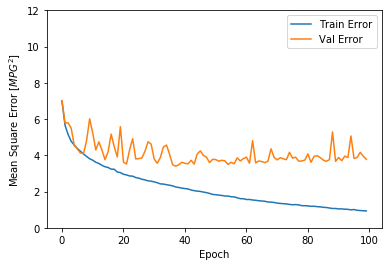

In [188]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error [MPG]')
#   plt.plot(hist['epoch'], hist['mean_absolute_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,10])
#   plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,12])
  plt.legend()
  plt.show()


plot_history(history)